In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

In [2]:
from tdse.propagator.spherical import Propagator_on_Spherical_Box_with_single_m

prop = Propagator_on_Spherical_Box_with_single_m(
    Nr=51, dr=0.2, m=1, lmax=1, Vr=0.0)

In [3]:
wf_t0 = prop.propagate_to_ground_state(norm_thres=1e-10)

iteration count at end: 74


# Particle propagation

In [4]:
q0_arr = np.array([[3.2, pi/2, 0.0], [9.1, pi/2, 0.0]])

In [5]:
dt, Nt = 0.1, 51
t_arr = dt * np.arange(Nt)

In [6]:
from numpy import asarray
def implicit_eq(dq, q, dt, Rlm, prop):
    _dq, _q, _Rlm = (asarray(_a) for _a in (dq, q, Rlm))
    _q_next = _q + _dq
    _h_sq = np.square(prop.wf.h_q(_q_next))
    _wf, _dq_wf = prop.wf.eval_wf_with_wf_deriv_at_q(_q_next, _Rlm)
    if _wf == 0: raise NotImplementedError("zero wavefunction at real space encountered")
    _eq = -_h_sq*_dq + prop.hbar/prop.mass*np.imag(_dq_wf/_wf)
    return _eq

In [7]:
wf = np.empty_like(wf_t0, dtype=np.complex)
wf[:] = wf_t0
wf_t = np.empty((Nt,)+wf_t0.shape, dtype=np.complex)
wf_t[0] = wf

q_arr = np.copy(q0_arr)
q_arr_t = np.empty((Nt,)+q0_arr.shape)
q_arr_t[0] = q0_arr

from scipy.optimize import root
dq0 = np.zeros((prop.wf.dim,), dtype=np.float)
for it in range(Nt-1):
    
    dt = t_arr[it+1] - t_arr[it]
    
    prop.propagate(wf, dt, Nt=1)
    wf_t[it+1] = wf
    Rlm = prop.wf.wf2Rlm(wf)
    
    for iq, q in enumerate(q_arr):
        eq_args = (q, dt, Rlm, prop)
        _lowers = (-prop.wf.r_max-q[0], -pi/2, -pi)
        _uppers = (prop.wf.r_max-q[0], pi/2, pi)
        opts = {'method':'broyden1', 
                'options':{'xtol':1.0, 'lowers':_lowers, 'uppers':_uppers}}
        raise_err, sol = False, None
        try: sol = root(implicit_eq, dq0, eq_args, **opts)
        except: raise_err = True
        raise_err &= sol.success if sol is not None else True
        if raise_err: raise RuntimeError(
            "Failed to evaluate dq at time index '{}' and particle index '{}'".format(it,iq))
        dq = sol.x
        q_arr[iq] += dq
    
    q_arr_t[it+1] = q_arr

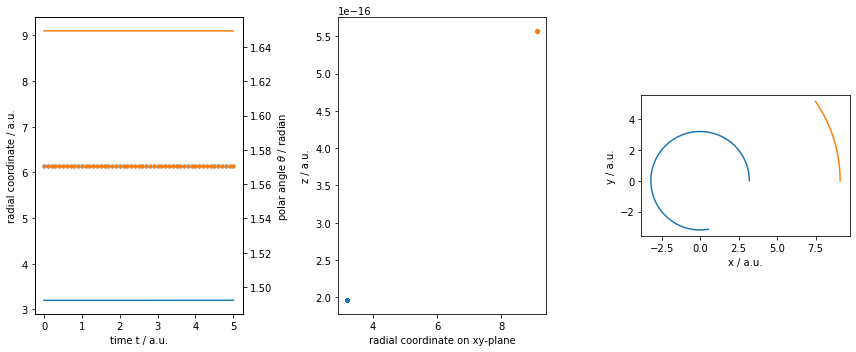

In [15]:
fig, (ax, axreal, axxy) = plt.subplots(ncols=3, figsize=(12,5))

axr, axtheta = ax, ax.twinx()
axr.set_xlabel("time t / a.u.")
axr.set_ylabel("radial coordinate / a.u.")
axtheta.set_ylabel(r"polar angle $\theta$ / radian")

axreal.set_xlabel("radial coordinate on xy-plane")
axreal.set_ylabel("z / a.u.")
# axreal.set_aspect(1.0)

axxy.set_xlabel("x / a.u.")
axxy.set_ylabel("y / a.u.")
axxy.set_aspect(1.0)

Nq = len(q0_arr)
for iq in range(Nq):
    r_t = q_arr_t[:,iq,0]
    theta_t = q_arr_t[:,iq,1]
    lr, = axr.plot(t_arr, r_t, '-')
    axtheta.plot(t_arr, theta_t, '.', color=lr.get_color())
    
    rho_t, z_t = r_t*np.sin(theta_t), r_t*np.cos(theta_t)
    axreal.plot(rho_t, z_t, '.', color=lr.get_color())
    
    phi_t = q_arr_t[:,iq,2]
    x_t, y_t = rho_t*np.cos(phi_t), rho_t*np.sin(phi_t)
    axxy.plot(x_t, y_t)

fig.tight_layout()

# fig.savefig("paricle-prop-m-{}-lmax-{}-test-3".format(prop.m, prop.lmax))

# Test evaluation of wavefunction and its partial derivatives

In [30]:
Rlm = prop.wf.wf2Rlm(wf)

In [31]:
r_arr = np.linspace(0., prop.wf.r_max-1e-8, num=21)
theta_arr = np.linspace(0., pi, num=29)
phi = 0.0

In [32]:
wf_sph = np.empty((r_arr.size, theta_arr.size), dtype=np.complex)
dq_wf_sph = np.empty((prop.wf.dim, r_arr.size, theta_arr.size), dtype=np.complex)
for ind in np.ndindex(*wf_sph.shape):
    r, theta = r_arr[ind[0]], theta_arr[ind[1]]
    wf_sph[ind], dq_wf_sph[np.index_exp[:]+ind] = prop.wf.eval_wf_with_wf_deriv_at_q([r,theta,phi], Rlm)

r,theta,phi == (0.0,0.0,0.0)
_Plm:[1. 1.]
_dtheta_Plm:[0. 0.]
r,theta,phi == (0.0,0.1121997376282069,0.0)
_Plm:[1.         0.99371221]
_dtheta_Plm:[-0.         -0.11196448]
r,theta,phi == (0.0,0.2243994752564138,0.0)
_Plm:[1.         0.97492791]
_dtheta_Plm:[-0.         -0.22252093]
r,theta,phi == (0.0,0.3365992128846207,0.0)
_Plm:[1.         0.94388333]
_dtheta_Plm:[-0.         -0.33027906]
r,theta,phi == (0.0,0.4487989505128276,0.0)
_Plm:[1.         0.90096887]
_dtheta_Plm:[-0.         -0.43388374]
r,theta,phi == (0.0,0.5609986881410345,0.0)
_Plm:[1.        0.8467242]
_dtheta_Plm:[-0.         -0.53203208]
r,theta,phi == (0.0,0.6731984257692414,0.0)
_Plm:[1.         0.78183148]
_dtheta_Plm:[-0.        -0.6234898]
r,theta,phi == (0.0,0.7853981633974483,0.0)
_Plm:[1.         0.70710678]
_dtheta_Plm:[-0.         -0.70710678]
r,theta,phi == (0.0,0.8975979010256552,0.0)
_Plm:[1.        0.6234898]
_dtheta_Plm:[-0.         -0.78183148]
r,theta,phi == (0.0,1.009797638653862,0.0)
_Plm:[1.     

r,theta,phi == (2.5999999975,2.8049934407051724,0.0)
_Plm:[ 1.         -0.94388333]
_dtheta_Plm:[-0.         -0.33027906]
r,theta,phi == (2.5999999975,2.9171931783333793,0.0)
_Plm:[ 1.         -0.97492791]
_dtheta_Plm:[-0.         -0.22252093]
r,theta,phi == (2.5999999975,3.029392915961586,0.0)
_Plm:[ 1.         -0.99371221]
_dtheta_Plm:[-0.         -0.11196448]
r,theta,phi == (2.5999999975,3.141592653589793,0.0)
_Plm:[1. 1.]
_dtheta_Plm:[0. 0.]
r,theta,phi == (3.119999997,0.0,0.0)
_Plm:[1. 1.]
_dtheta_Plm:[0. 0.]
r,theta,phi == (3.119999997,0.1121997376282069,0.0)
_Plm:[1.         0.99371221]
_dtheta_Plm:[-0.         -0.11196448]
r,theta,phi == (3.119999997,0.2243994752564138,0.0)
_Plm:[1.         0.97492791]
_dtheta_Plm:[-0.         -0.22252093]
r,theta,phi == (3.119999997,0.3365992128846207,0.0)
_Plm:[1.         0.94388333]
_dtheta_Plm:[-0.         -0.33027906]
r,theta,phi == (3.119999997,0.4487989505128276,0.0)
_Plm:[1.         0.90096887]
_dtheta_Plm:[-0.         -0.43388374]
r,th

r,theta,phi == (5.7199999945,1.9073955396795172,0.0)
_Plm:[ 1.         -0.33027906]
_dtheta_Plm:[-0.         -0.94388333]
r,theta,phi == (5.7199999945,2.019595277307724,0.0)
_Plm:[ 1.         -0.43388374]
_dtheta_Plm:[-0.         -0.90096887]
r,theta,phi == (5.7199999945,2.131795014935931,0.0)
_Plm:[ 1.         -0.53203208]
_dtheta_Plm:[-0.        -0.8467242]
r,theta,phi == (5.7199999945,2.243994752564138,0.0)
_Plm:[ 1.        -0.6234898]
_dtheta_Plm:[-0.         -0.78183148]
r,theta,phi == (5.7199999945,2.356194490192345,0.0)
_Plm:[ 1.         -0.70710678]
_dtheta_Plm:[-0.         -0.70710678]
r,theta,phi == (5.7199999945,2.4683942278205517,0.0)
_Plm:[ 1.         -0.78183148]
_dtheta_Plm:[-0.        -0.6234898]
r,theta,phi == (5.7199999945,2.5805939654487586,0.0)
_Plm:[ 1.        -0.8467242]
_dtheta_Plm:[-0.         -0.53203208]
r,theta,phi == (5.7199999945,2.6927937030769655,0.0)
_Plm:[ 1.         -0.90096887]
_dtheta_Plm:[-0.         -0.43388374]
r,theta,phi == (5.7199999945,2.80499

r,theta,phi == (8.8399999915,1.5707963267948966,0.0)
_Plm:[1.000000e+00 6.123234e-17]
_dtheta_Plm:[-0. -1.]
r,theta,phi == (8.8399999915,1.6829960644231035,0.0)
_Plm:[ 1.         -0.11196448]
_dtheta_Plm:[-0.         -0.99371221]
r,theta,phi == (8.8399999915,1.7951958020513104,0.0)
_Plm:[ 1.         -0.22252093]
_dtheta_Plm:[-0.         -0.97492791]
r,theta,phi == (8.8399999915,1.9073955396795172,0.0)
_Plm:[ 1.         -0.33027906]
_dtheta_Plm:[-0.         -0.94388333]
r,theta,phi == (8.8399999915,2.019595277307724,0.0)
_Plm:[ 1.         -0.43388374]
_dtheta_Plm:[-0.         -0.90096887]
r,theta,phi == (8.8399999915,2.131795014935931,0.0)
_Plm:[ 1.         -0.53203208]
_dtheta_Plm:[-0.        -0.8467242]
r,theta,phi == (8.8399999915,2.243994752564138,0.0)
_Plm:[ 1.        -0.6234898]
_dtheta_Plm:[-0.         -0.78183148]
r,theta,phi == (8.8399999915,2.356194490192345,0.0)
_Plm:[ 1.         -0.70710678]
_dtheta_Plm:[-0.         -0.70710678]
r,theta,phi == (8.8399999915,2.468394227820551

In [102]:
from vis.plot import construct_polar_mesh_for_colormesh
r_cmesh, theta_cmesh = construct_polar_mesh_for_colormesh(r_arr, theta_arr)

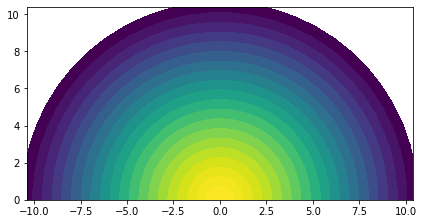

In [103]:
fig, ax = plt.subplots()
ax.pcolormesh(r_cmesh, theta_cmesh, wf_sph.real)
ax.set_aspect(1.0)
ax.set_ylim(0,prop.wf.r_max), ax.set_xlim(-prop.wf.r_max,prop.wf.r_max)
fig.tight_layout()
# fig.savefig("wf-interp-test-2.png")

In [104]:
from tdse.analytic import spherical_jn_zeros

jl_zero_1 = spherical_jn_zeros(0, 1)

In [105]:
from scipy.special import spherical_jn

R00 = spherical_jn(0, (jl_zero_1 / prop.r_max) * r_arr)
g00 = r_arr * R00
# prop.wf_class.normalize(g00, prop.dr)

In [106]:
R00

array([1.00000000e+00, 9.95892735e-01, 9.83631643e-01, 9.63397762e-01,
       9.35489284e-01, 9.00316316e-01, 8.58393692e-01, 8.10331958e-01,
       7.56826729e-01, 6.98646586e-01, 6.36619773e-01, 5.71619934e-01,
       5.04551153e-01, 4.36332594e-01, 3.67883011e-01, 3.00105440e-01,
       2.33872322e-01, 1.70011371e-01, 1.09292406e-01, 5.24154081e-02,
       9.61538546e-10])

In [67]:
wf_sph[:,0]

array([1.67275332e-02+0.j, 1.66386827e-02+0.j, 1.64339983e-02+0.j,
       1.60962066e-02+0.j, 1.56302705e-02+0.j, 1.50430186e-02+0.j,
       1.43430210e-02+0.j, 1.35404507e-02+0.j, 1.26468978e-02+0.j,
       1.16751757e-02+0.j, 1.06390992e-02+0.j, 9.55324616e-03+0.j,
       8.43271178e-03+0.j, 7.29284980e-03+0.j, 6.14901553e-03+0.j,
       5.01630810e-03+0.j, 3.90932353e-03+0.j, 2.84191278e-03+0.j,
       1.82696457e-03+0.j, 8.76201199e-04+0.j, 1.60731545e-11+0.j])

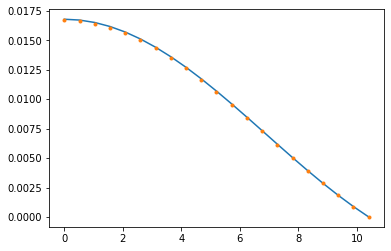

In [77]:
fig, ax = plt.subplots()
ax.plot(r_arr, R00*0.0168)
ax.plot(r_arr, wf_sph[:,0].real, '.')

In [110]:
from importlib import reload

import tdse.propagator.spherical
reload(tdse.propagator.spherical)
import tdse.propagator._base
reload(tdse.propagator._base)

SyntaxError: invalid syntax (spherical.py, line 216)